In [ ]:
%load_ext autoreload
%autoreload 2

# import ST_utils
# import train_STAligner
import sys
sys.path.append('/home/chenjn/rna2adt')

import STAligner
import train_STAligner
import ST_utils

import warnings
warnings.filterwarnings("ignore")

# # the location of R (used for the mclust clustering)
# import os
# os.environ['R_HOME'] = "/home/xzhou/anaconda3/envs/PyG/lib/R"
# os.environ['R_USER'] = "/home/xzhou/anaconda3/envs/PyG/lib/python3.8/site-packages/rpy2"
# import rpy2.robjects as robjects
# import rpy2.robjects.numpy2ri

import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import scipy.sparse as sp
import scipy.linalg
from scipy.sparse import csr_matrix

import torch
used_device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')

from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import fowlkes_mallows_score as FMI
from sklearn.metrics import silhouette_score as SC

from utils import find_resolution, find_res_label

from sklearn.cluster import KMeans

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
refdata = sc.read_h5ad('/home/chenjn/rna2adt/baseline/scPROTEIN/downstream_application/clinical_proteomic_application/data/ECCITE_seq_processed.h5ad')
adata = sc.read_h5ad("/data/user/liwb/project/rna2adt/A_run_test/downstream/clinical_proteomic_application/emb/ECCITE_step1.h5ad")
batch_key = 'donor_type'

np.unique(adata.obs[batch_key])

array([0, 1])

In [27]:
Batch_list = []
adj_list = []
section_ids = np.unique(adata.obs[batch_key]).tolist()

adata.obs_names = [str(x) + '_' + str(y) for x, y in zip(adata.obs_names, adata.obs[batch_key])]  

for section_id in section_ids:
    tmpdata = adata[adata.obs[batch_key] == section_id]
    # tmpdata.X = csr_matrix(tmpdata.X)
    # adata.var_names_make_unique(join="++")

    # make spot name unique
    # tmpdata.obs_names = [x + '_' + section_id + '_' + y for x, y in zip(tmpdata.obs_names, tmpdata.obs['celltype.l2'])]  
    # adata.obs_names = [x + '_' + section_id for x in adata.obs_names]  
    # print(tmpdata.obs_names)  
    
    # Constructing the spatial network
    ST_utils.Cal_Spatial_Net(tmpdata, k_cutoff=10, model='KNN') # the spatial network are saved in adata.uns[‘adj’]
    # ST_utils.Stats_Spatial_Net(adata) # plot the number of spatial neighbors
       
    # Normalization
    # sc.pp.highly_variable_genes(tmpdata, flavor="seurat_v3", n_top_genes=10000)
    # sc.pp.normalize_total(tmpdata)
    # sc.pp.log1p(tmpdata)
    print(tmpdata.X)

    # adata = adata[:, adata.var['highly_variable']]
    adj_list.append(tmpdata.uns['adj'])
    Batch_list.append(tmpdata)

------Calculating spatial graph...
The graph contains 27670 edges, 2767 cells.
10.0000 neighbors per cell on average.
[[-0.0409832   0.03787391  0.02331008 ...  0.03483823 -0.05909126
   0.00675847]
 [-0.03255586  0.03551623  0.02198967 ...  0.03059432 -0.06692347
   0.00688186]
 [-0.02669985  0.03553714  0.0375326  ...  0.05089549 -0.03834269
   0.03355153]
 ...
 [ 0.00329479  0.00706804 -0.01178668 ...  0.02147313 -0.01744538
   0.00185121]
 [ 0.02323383  0.02439771 -0.00194696 ...  0.01879665 -0.01973482
   0.00841208]
 [-0.03173009  0.02978305  0.027476   ...  0.01612667 -0.03033495
   0.01165648]]
------Calculating spatial graph...
The graph contains 26340 edges, 2634 cells.
10.0000 neighbors per cell on average.
[[-0.03314832  0.04193092  0.03786334 ...  0.03975049 -0.04927126
   0.02060362]
 [-0.02354586  0.02668162  0.0260433  ...  0.03130917 -0.04892687
   0.02712219]
 [-0.01676681  0.0379834   0.01397908 ...  0.03637383 -0.05613445
   0.01688675]
 ...
 [-0.03487501  0.0262011

In [28]:
# iter_comb is used to specify the order of integration. For example, (0, 1) means slice 0 will be algined with slice 1 as reference.
iter_comb = [(i, i + 1) for i in range(len(section_ids) - 1)]
print(iter_comb)

# Here, to reduce GPU memory usage, each slice is considered as a subgraph for training.
adata_af = train_STAligner.train_STAligner_subgraph(adata, verbose=True, knn_neigh = 2, 
                                                    n_epochs = 600, iter_comb = iter_comb, 
                                                    Batch_list=Batch_list, device=used_device,
                                                    margin=0.01, batch_key=batch_key,
                                                    label_key=None)

[(0, 1)]
TriAE(
  (enc_1): Linear(in_features=256, out_features=128, bias=True)
  (enc_2): Linear(in_features=128, out_features=64, bias=True)
  (z_layer): Linear(in_features=64, out_features=32, bias=True)
  (dec_1): Linear(in_features=32, out_features=64, bias=True)
  (dec_2): Linear(in_features=64, out_features=128, bias=True)
  (x_bar_layer): Linear(in_features=128, out_features=256, bias=True)
)
Train with STAligner...


  0%|          | 0/100 [00:00<?, ?it/s]

Update spot triplets at epoch 500


100%|██████████| 100/100 [00:02<00:00, 44.05it/s]


In [29]:
adata1 = ad.AnnData(adata_af.obsm['STAligner'], obs=adata_af.obs)
adata1.obs.index = refdata.obs.index
sc.pp.neighbors(adata1)
sc.tl.louvain(adata1)

adata1.write_h5ad("/data/user/liwb/project/rna2adt/A_run_test/downstream/clinical_proteomic_application/emb/ECCITE_step2.h5ad")

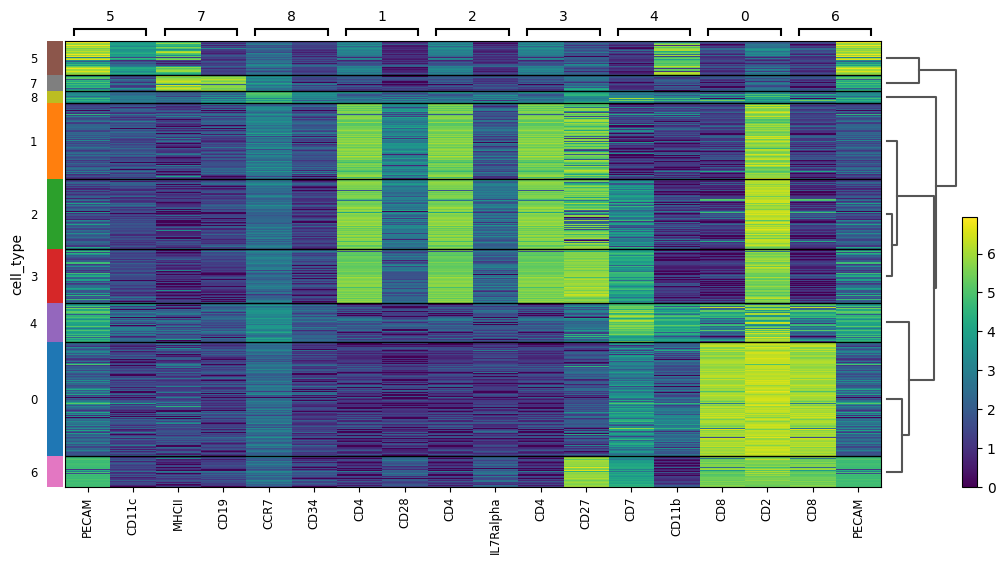

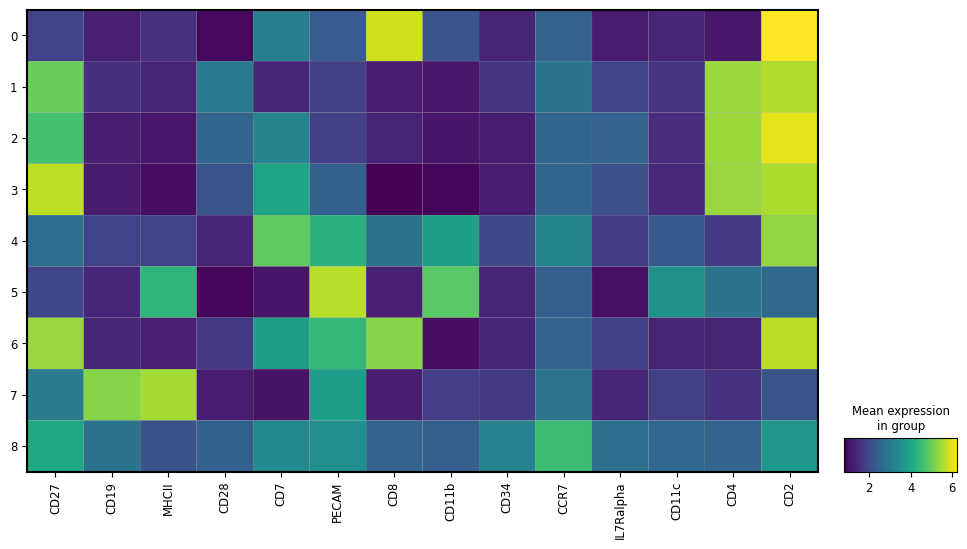

In [30]:
import matplotlib.pyplot as plt
refdata.obs['cell_type'] = adata1.obs['louvain']

sc.tl.rank_genes_groups(refdata, 'cell_type')
sc.pl.rank_genes_groups_heatmap(refdata, n_genes=2, 
                                figsize=(12,6), 
                                # colormap='plasma', 
                                show=False,
                                )
plt.savefig("./ECCITE_figure/heatmap/eccite.png")
plt.savefig("./ECCITE_figure/heatmap/eccite.svg")

marker = list(set(np.array(pd.DataFrame(refdata.uns['rank_genes_groups']['names']).head(2)).reshape(-1)))
# pd.DataFrame(marker_genes_ori).to_csv('../data/' + data_name + '/mark_ori.csv')

sc.pl.matrixplot(refdata, marker, groupby='cell_type', 
                 figsize=(12,6), 
                 show=False,
                 )
plt.savefig("./ECCITE_figure/marker/eccite.png")
plt.savefig("./ECCITE_figure/marker/eccite.svg")


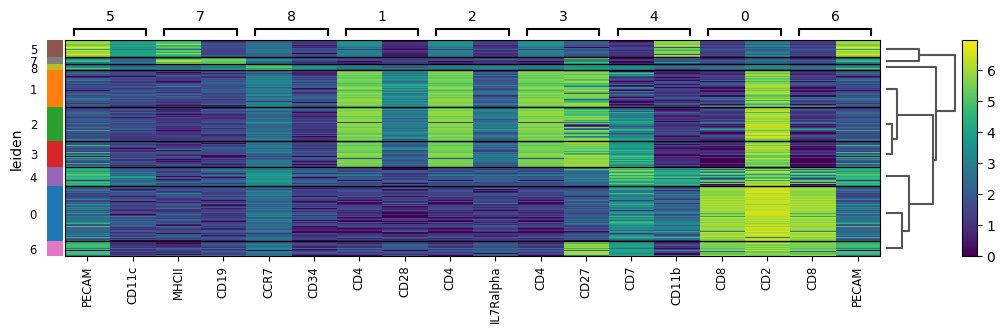

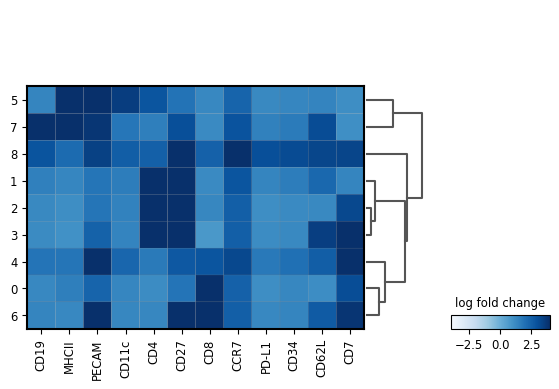

In [31]:
refdata.obs['leiden'] = adata1.obs['louvain']
markers = ['CD19', 'MHCII', 'PECAM', 'CD11c', 'CD4', 'CD27','CD8','CCR7','PD-L1','CD34','CD62L','CD7']

sc.tl.rank_genes_groups(refdata, 'leiden')
sc.pl.rank_genes_groups_heatmap(
    refdata, n_genes=2, 
    figsize=(12,3), 
    # colormap='plasma', 
    # save='/' + 'ECCITE' + '_h1' + ".png"
)

# marker = list(set(np.array(pd.DataFrame(refdata.uns['rank_genes_groups']['names']).head(2)).reshape(-1)))

sc.pl.rank_genes_groups_matrixplot(
    refdata,
    # values_to_plot="logfoldchanges",
    var_names = markers,
    cmap='Blues',
    vmin=-4,
    vmax=4,
    min_logfoldchange=3,
    colorbar_title='log fold change',
)

In [32]:
for i in np.unique(refdata.obs['cell_type']):
    tmp = refdata[refdata.obs['cell_type'] == i]
    tmp1 = tmp[tmp.obs[batch_key] == tmp.obs[batch_key][0]]
    print(i, tmp1.shape[0] / tmp.shape[0])

0 0.7166546503244412
1 0.24808743169398906
2 0.5491803278688525
3 0.5038284839203675
4 0.44562899786780386
5 0.8236714975845411
6 0.23180592991913745
7 0.5238095238095238
8 0.087248322147651
